In [71]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
import scipy.ndimage
import time
import scipy.misc


In [72]:
def cart2pol(x, y):
    mag = np.sqrt(x**2 + y**2)
    ang = np.arctan2(y, x)
    return mag, ang

def pol2cart(mag, ang):
    x = mag * np.cos(ang)
    y = mag * np.sin(ang)
    return x, y

def norm2(v):
    """2-norm of a 2D vector (faster than np.linalg.norm)"""
    return (v[0]**2 + v[1]**2)**.5

In [73]:
def patch_transform(x, y, dx, dy):
    L = np.hypot(dx, dy)

    if L != 0:
        cx = float(dx) / L
        sx = float(dy) / L
    else:
        # Account for division by zero
        cx, sx = 0, 1

    trans1 = mpl.transforms.Affine2D().scale(L, 1)
    trans2 = mpl.transforms.Affine2D.from_values(cx, sx, -sx, cx, 0.0, 0.0)
    trans3 = mpl.transforms.Affine2D().translate(x, y)
    trans = trans1 + trans2 + trans3
    return trans.frozen()

def pltsin(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(5):
    pltsin(ax, ['b', 'r'])
    time.sleep(1)

In [109]:
# Drawing Options
BAL_NOT_VEC = True      # Draw balls (True) or vectors (False).ipynb_checkpoints/
RANDOM_BACK = False     # Replace background with flashing colors?
RANDOM_BALL = False     # Replace balls with flashing colors?
DRAW_TARGET = True      # Show line from groups to their targets?
# Wall Settings
WALL_MARGIN = 50        # Pixels from edge of screen for boundary.
WALL_FORCE = 100        # Force applied to balls outside boundary.
# Random Parameters
MAX_FPS = 100           # Maximum frame per second for display.
GROUPS = 2              # Number of groups to have displayed on the GUI.
# Target Settings
TARGET_FORCE = 500      # Force exerted by the targets on the boid groups.
TRIG_DIST = 100         # Distance to target where target gets changed.
MINI_DIST = 200         # Target must be this far away when recreated.
# Boid Settings
MAX_SIZE = 15           # Largest radius a boid is allowed to have.
MIN_SIZE = 10           # Smallest radius a boid may be built with.

n_boid_groups = 1
n_boids = 20
boid_size = 1.
boid_max_speed = 400.         # maximum speed for boids [pixels/sec]

mask_fname = "/home/archels/vienna_hackathon/boids/boids_world.png"
mask = sp.misc.imread(mask_fname)
mask = np.mean(mask, axis=2).astype(np.bool)  # convert to black and white

max_x = mask.shape[1]
max_y = mask.shape[0]

#
#    boundary
#

wall_restitution = False


# Check the settings up above for errors.
assert MINI_DIST > TRIG_DIST, 'Targets must be set beyond trigger point.'
assert MAX_SIZE > MIN_SIZE, 'A minimum may not be larger than maximum.'

In [110]:
class BoidWorld:
    def __init__(self, max_x, max_y, mask):
        self.max_x = max_x
        self.max_y = max_y
        self.mask = mask
        self._updateSurfaceNormals()
    
    def _updateSurfaceNormals(self):
        """N.B. surface normals point into the walls"""
        mask_blurred = sp.ndimage.filters.gaussian_filter(self.mask.astype(np.float), sigma=15)
        self._mask_blurred = mask_blurred  # XXX: for debug only
        self._normals = np.transpose(np.stack(np.gradient(mask_blurred)), (1, 2, 0))
    
    def inCollision(self, p):
        x, y = p
        x = int(np.round(x))
        y = int(np.round(y))
        return self.mask[self.max_y - y - 1, x] == 0

    def getSurfaceNormalVector(self, p):
        """return a normalised vector"""
        x, y = p
        x = int(np.round(x))
        y = int(np.round(y))
        n = self._normals[self.max_y - y - 1, x, ...]
        return (n / norm2(n))[::-1]

    def getSurfaceNormals(self):
        return self._normals
    
    def getBlurredMask(self):
        return self._mask_blurred

In [111]:
class BoidGroup:

    # Simple collection for managing boid agents.

    def __init__(self):
        self.boids = []
        self.controllers = []
        self.positions_dirty = False
        self.center_dirty = True
        self.group_center = np.zeros(2)
        self.vector_dirty = True
        self.group_vector = np.zeros(2)

    def add_boid(self, boid):
        self.boids.append(boid)

    def step_velocity(self):
        assert not self.positions_dirty, 'Position must be updated first.'
        self.velocities_dirty = False
        self.positions_dirty = True
        for boid in self.boids:
            boid.step_velocity(self, self.boids)

    def step_position(self, dt):
        assert not self.velocities_dirty, 'Velocity must be updated first.'
        self.velocities_dirty = True
        self.positions_dirty = False
        self.center_dirty = True
        for boid in self.boids:
            boid.step_position(dt)

    def add_controller(self, controller, parms):
        self.controllers.append((controller, parms))

    def run_controls(self, t, dt):
        for control, parms in self.controllers:
            for boid in self.boids:
                control(self, boid, dt, parms)

    def boids_ctrl_motivate(self, boid, dt, parms):
        # direction vector
        v = parms["target"] - boid.position
        v /= norm2(v)
        # adjust velocity according to force and scale
        boid.velocity += v * parms["force"] * dt
    
    
    def initial_plot(self, ax):
        """# draw the group's target if enabled.
        if plt_tg:
            center = group.center
            target = group.target
            self.create_line(center.x, center.y, target.x, target.y,
                             fill=choice(self.PALETTE), width=3)"""
        self.plt_boid_arrows = []
        boid_positions = np.empty((2, 0))
        for boid in self.boids:
            patch = mpl.patches.Arrow(boid.position[0], boid.position[1], boid.velocity[0], boid.velocity[1], width=10.)
            ax.add_patch(patch)
            self.plt_boid_arrows.append(patch)
            boid_positions = np.hstack([boid_positions, boid.position[:, np.newaxis]])
            print("Plotting at: " + str((boid.position[0], boid.position[1], boid.velocity[0], boid.velocity[1])))
        self.plt_boid_scatterpoints = ax.scatter(boid_positions[0, :], boid_positions[1, :], marker="o", color="k")
        ax.imshow(mask, extent=[0., max_x, 0., max_y], aspect="equal", interpolation="none", cmap=plt.cm.gray, alpha=.25)
        ax.set_aspect("equal")
        fig.canvas.draw()

    def update_plot(self, ax):
        """# draw the group's target if enabled.
        if plt_tg:
            center = group.center
            target = group.target
            self.create_line(center.x, center.y, target.x, target.y,
                             fill=choice(self.PALETTE), width=3)"""

        boid_positions = np.empty((2, 0))
        for boid, patch in zip(self.boids, self.plt_boid_arrows):            
            patch._patch_transform = patch_transform(boid.position[0], boid.position[1], boid.velocity[0], boid.velocity[1])
            boid_positions = np.hstack([boid_positions, boid.position[:, np.newaxis]])

        self.plt_boid_scatterpoints.set_offsets(np.c_[boid_positions[0, :], boid_positions[1, :]])
        fig.canvas.draw()

    def center(self):
        if self.center_dirty:
            self.group_center[:] = 0.
            for boid in self.boids:
                self.group_center += boid.position
            self.group_center /= float(len(self.boids))
            self.center_dirty = False
        return self.group_center

    def vector(self):
        if self.vector_dirty:
            self.group_vector[:] = 0.
            for boid in self.boids:
                self.group_vector += boid.velocity
            self.group_vector /= float(len(self.boids))
            self.vector_dirty = False
        return self.group_vector
    

In [116]:


################################################################################

class BoidAgent:

    # Implements all three boid rules.

    RULE_1_SCALE = 10  # Scale the clumping factor.
    RULE_2_SCALE = 3    # Scale the avoiding factor.
    RULE_2_SPACE = 1    # Avoid when inside of space.
    RULE_3_SCALE = 100  # Scale the schooling factor.

    def __init__(self, position, velocity, radius, max_speed, world):
        self.position = position
        self.velocity = velocity
        self.__update = np.zeros(2)
        self.radius = radius
        self.max_speed = max_speed
        self.world = world

    def step_velocity(self, group, boids):
        # Filter self out of boids.
        others = [boid for boid in boids if boid is not self]
        # Run through the boid rules.
        vector_1 = self.__rule_1(others)
        # vector_1 = (group.center - self.position) / 100
        vector_2 = self.__rule_2(others)
        vector_3 = self.__rule_3(others)
        # vector_3 = (group.vector - self.velocity) / 100
        # Save the results.
        self.__update = vector_1 + vector_2 + vector_3

    def step_position(self, dt):
        # Update to new velocity.
        self.velocity += self.__update
        # Limit the velocity as needed.
        if norm2(self.velocity) > self.max_speed:
            self.velocity /= norm2(self.velocity) / self.max_speed
        new_pos = self.position + self.velocity * dt
        if self.world.inCollision(new_pos):
            #print("Collision, pos = " + str(self.position))
            #print("\tv = " + str(self.velocity))
            n = self.world.getSurfaceNormalVector(self.position)
            #print("\tn = " + str(n))
            #print("\tv in direction of n = " + str(np.dot(n, self.velocity)))
            self.velocity -= n * np.abs(np.dot(n, self.velocity))  # subtract the velocity component that points into the wall
            #print("\tnew v = " + str(self.velocity))
            new_pos = self.position + self.velocity * dt
        
        while self.world.inCollision(new_pos):
            # new position is still in collision -- probably due to numerical error
            # move boid slightly away from the wall
            delta = 1E-1
            new_pos += delta * n

        self.position = new_pos

    def __rule_1(self, boids):
        # Simulate the clumping factor.
        vector = np.zeros(2)
        for boid in boids:
            vector += boid.position
        vector /= len(boids)
        return (vector - self.position) / self.RULE_1_SCALE

    def __rule_2(self, boids):
        # Simulate the avoiding factor.
        vector = np.zeros(2)
        for boid in boids:
            delta = np.linalg.norm(boid.position - self.position)
            space = (boid.radius + self.radius) * (self.RULE_2_SPACE + 1)
            if delta < space:
                vector += (self.position - boid.position)
        return vector / self.RULE_2_SCALE

    def __rule_3(self, boids):
        # Simulate the schooling factor.
        vector = np.zeros(2)
        weight = 0.
        for boid in boids:
            r2 = boid.radius**2
            vector += boid.velocity * r2
            weight += r2
        vector /= len(boids) * weight
        return (vector - self.velocity) / self.RULE_3_SCALE

In [117]:
#
#  initialise boids
#

boid_world = BoidWorld(max_x, max_y, mask)

boid_groups = []
for i in range(n_boid_groups):
    group = BoidGroup()
    # Create a new boid for current group.
    for boid in range(n_boids):
        # Place the boid somewhere on screen.
        pos_OK = False
        while not pos_OK:
            x = np.random.randint(0, max_x)
            y = np.random.randint(0, max_y)
            pos_OK = not boid_world.inCollision((x, y))
        position = np.array([x, y], dtype=np.float)
        # Give it a random velocity (within 400).
        velocity = pol2cart(sp.stats.uniform(boid_max_speed/2./10., boid_max_speed).rvs(), np.random.randint(1, 360))
        # Create a boid
        boid = BoidAgent(position, velocity, radius=boid_size, max_speed=boid_max_speed, world=boid_world)
        group.add_boid(boid)

    #group.add_control(boids_ctrl_wall, {"restitution" : wall_restitution})

    x_tg = np.random.randint(WALL_MARGIN, max_x - WALL_MARGIN)
    y_tg = np.random.randint(WALL_MARGIN, max_y - WALL_MARGIN)
    group.add_controller(BoidGroup.boids_ctrl_motivate, {"target" : np.array([x_tg, y_tg], dtype=np.float), "force" : 0.01})
    boid_groups.append(group)

<IPython.core.display.Javascript object>


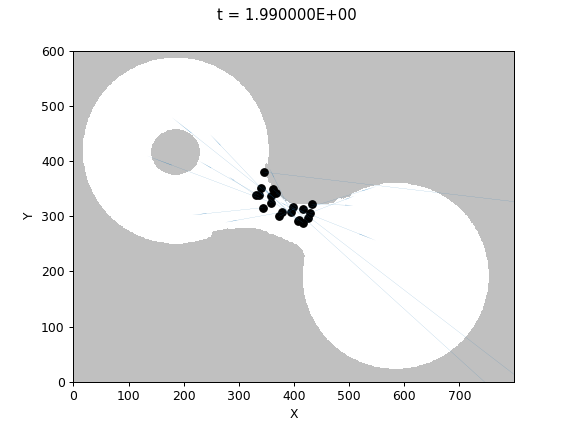

Plotting at: (77.0, 323.0, 133.69085655321425, 189.2505910130601)
Plotting at: (543.0, 125.0, 180.79999732333522, -242.01996988730727)
Plotting at: (681.0, 308.0, 90.27672334546277, -65.587384135715666)
Plotting at: (527.0, 220.0, 24.506471760351353, -26.896092397496751)
Plotting at: (304.0, 431.0, 42.711603256380727, -87.135155825100298)
Plotting at: (509.0, 196.0, -98.189489604884514, 54.204853785759376)
Plotting at: (466.0, 86.0, 16.121568827827389, -43.036431265264575)
Plotting at: (739.0, 157.0, 115.73038547469247, -114.20048546688803)
Plotting at: (364.0, 303.0, 224.73950046438955, -260.19232082181793)
Plotting at: (617.0, 95.0, 70.33141227563776, -403.49289744465756)
Plotting at: (198.0, 547.0, -6.9038815742821864, -312.36434111587982)
Plotting at: (596.0, 70.0, -194.79120732039431, 175.90258090936325)
Plotting at: (195.0, 351.0, 309.51340974458162, -66.738971214288725)
Plotting at: (222.0, 264.0, -113.48657608937459, 266.42835025250275)
Plotting at: (665.0, 185.0, 111.916501896

In [118]:
dt = 1E-2
t_stop = 2.


#
#
#


fig,ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, max_x)
ax.set_ylim(0, max_y)

plt_tg = None

t = 0.
i = 0
group.initial_plot(ax)
while t < t_stop:
    fig.suptitle("t = " + "{0:E}".format(t))
    for group in boid_groups:
        group.run_controls(t, dt)
        group.step_velocity()
        group.step_position(dt)
        group.update_plot(ax)
    
    time.sleep(.001)
    
    t += dt

<IPython.core.display.Javascript object>


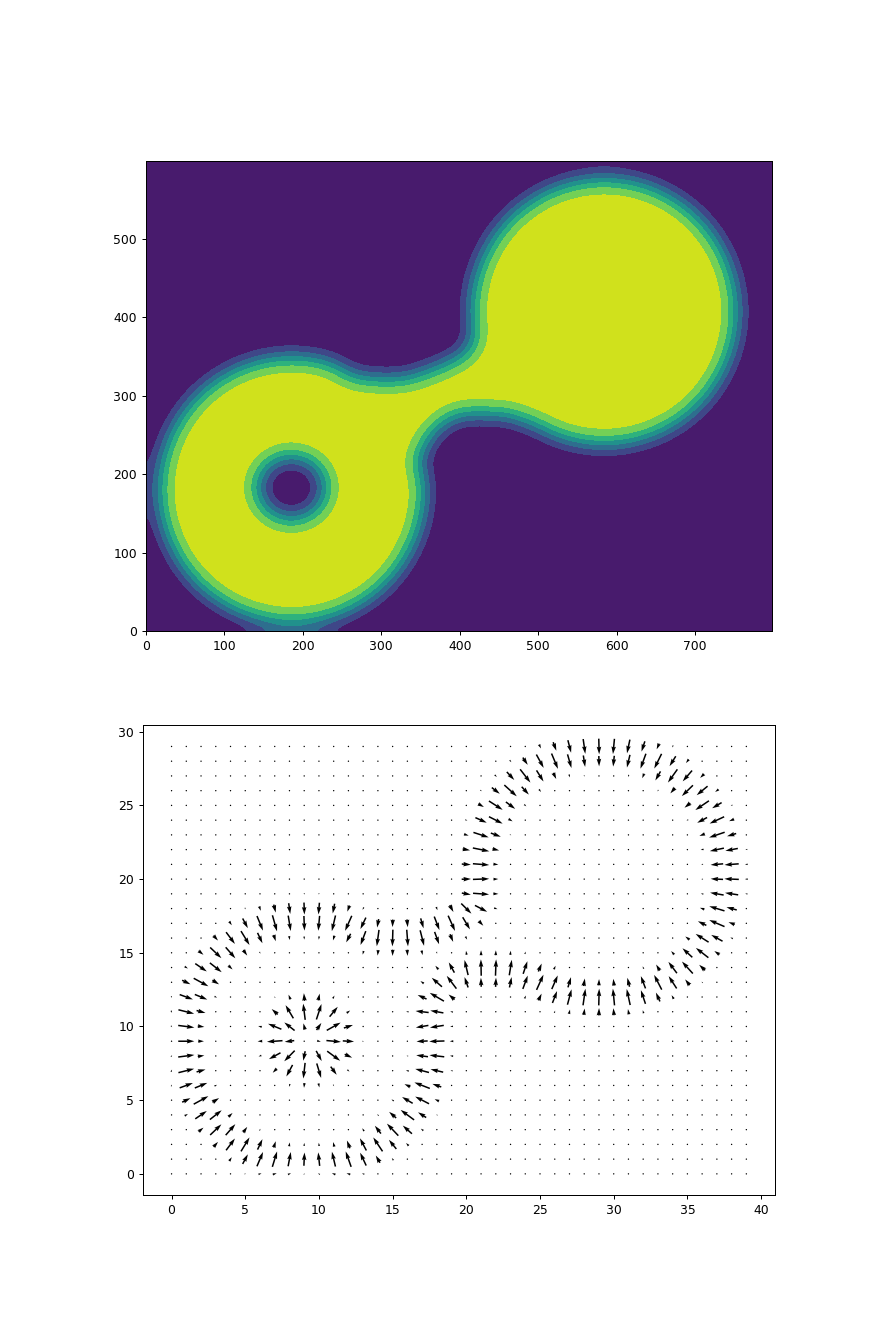

In [119]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 15))
normals = boid_world.getSurfaceNormals()
stride = 20
ax[0].contourf(boid_world.getBlurredMask())
ax[0].set_aspect("equal")

ax[1].quiver(normals[::stride, ::stride, 1], normals[::stride, ::stride, 0], pivot="mid", scale=1E0)
ax[1].set_aspect("equal")

In [ ]:
"""

def check_target(self):
    for group in self.groups:
        # Is the center of the group within (100) pixels of target?
        if (group.center - group.target).magnitude <= self.TRIG_DIST:
            # Adjust target to be over (200) pixels away.
            while (group.center - group.target).magnitude <= self.MINI_DIST:
                minimum = self.WALL_MARGIN
                width = self.width - minimum
                height = self.height - minimum
                x = randint(minimum, width)
                y = randint(minimum, height)
                group.target = Vector2(x, y)
            # Change the ball colors if they are not random.
            if not self.RANDOM_BALL:
                if self.PALETTE_MODE:
                    palette = choice(self.BALL_PALETTE)
                    self.BALL_PALETTE.remove(palette)
                    self.BALL_PALETTE.append(group.palette)
                    # Assign colors from new palette.
                    for boid, color in zip(group.boids, palette):
                        boid.color = color
                    group.palette = palette
                else:
                    # Assign a random color from palette.
                    for boid in group.boids:
                        boid.color = choice(self.COLORS)


def force_wall(self, group, boid, seconds):
    # Left and Right walls.
    if boid.position.x < self.WALL_MARGIN:
        boid.velocity.x += self.WALL_FORCE * seconds
    elif boid.position.x > self.width - self.WALL_FORCE:
        boid.velocity.x -= self.WALL_FORCE * seconds
    # Upper and Lower walls.
    if boid.position.y < self.WALL_MARGIN:
        boid.velocity.y += self.WALL_FORCE * seconds
    elif boid.position.y > self.height - self.WALL_FORCE:
        boid.velocity.y -= self.WALL_FORCE * seconds

def bounce_wall(self, group, boid, seconds):
    # Left and Right walls.
    if boid.position.x < self.WALL_MARGIN:
        if boid.velocity.x < 0:
            boid.velocity.x *= -1
    elif boid.position.x > self.width - self.WALL_MARGIN:
        if boid.velocity.x > 0:
            boid.velocity.x *= -1
    # Upper and Lower walls.
    if boid.position.y < self.WALL_MARGIN:
        if boid.velocity.y < 0:
            boid.velocity.y *= -1
    elif boid.position.y > self.height - self.WALL_MARGIN:
        if boid.velocity.y > 0:
            boid.velocity.y *= -1

"""